In [57]:
import re
import math
import warnings
import tqdm
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
# from sympy import symbols, Eq, solve
from matplotlib.pyplot import MultipleLocator
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
warnings.filterwarnings("ignore")

In [58]:
data1 = pd.read_excel('3b数据.xlsx').drop(['数据集划分'], axis=1)
data1.rename(columns={'HM_volume': 'HM_volume.0', 
                      'HM_ACA_R_Ratio': 'HM_ACA_R_Ratio.0', 
                      'HM_MCA_R_Ratio': 'HM_MCA_R_Ratio.0', 
                      'HM_PCA_R_Ratio': 'HM_PCA_R_Ratio.0', 
                      'HM_Pons_Medulla_R_Ratio': 'HM_Pons_Medulla_R_Ratio.0', 
                      'HM_Cerebellum_R_Ratio': 'HM_Cerebellum_R_Ratio.0', 
                      'HM_ACA_L_Ratio':'HM_ACA_L_Ratio.0', 
                      'HM_MCA_L_Ratio':'HM_MCA_L_Ratio.0', 
                      'HM_PCA_L_Ratio':'HM_PCA_L_Ratio.0', 
                      'HM_Pons_Medulla_L_Ratio':'HM_Pons_Medulla_L_Ratio.0', 
                      'HM_Cerebellum_L_Ratio':'HM_Cerebellum_L_Ratio.0'
                     }, inplace=True)
data1.shape

(130, 290)

In [59]:
# list(data1.columns)

In [60]:
# 转换独热编码
xueya_list = []
for i in data1['血压']:
    y1 = i.split('/')[0]
    y2 = i.split('/')[1]
    if int(y1) > 139 or int(y1) < 90:
        status_i = 0
    elif int(y2) > 89 or int(y2) < 60:
        status_i = 0
    else:
        status_i = 1
    xueya_list.append(status_i)
data1['血压'] = np.array(xueya_list)
data1['性别_男'] = data1['性别'].apply(lambda x: 1 if x == '男' else 0)
data1['性别_女'] = data1['性别'].apply(lambda x: 1 if x == '女' else 0)
data1 = data1.drop(columns=['性别'])
x = data1['年龄'].values
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x.reshape(-1, 1))
binarizer = Binarizer(threshold=0.5)
x_binarized = binarizer.fit_transform(x_normalized)
data1['年龄'] = x_binarized
data1 = data1.drop(['流水号'], axis = 1)

In [61]:
# 归一化
import re

# 使用正则表达式来匹配列名中的末尾标识符（.1到.8）
pattern = r'\.\d+$'

hm_columns = data1.filter(like='HM_').columns.tolist()
ed_columns = data1.filter(like='ED_').columns.tolist()

# 获取匹配'.1'到'.8'的列名
hm_match_columns = [col for col in hm_columns if re.search(pattern, col)]
ed_match_columns = [col for col in ed_columns if re.search(pattern, col)]

# 将匹配的列与相应的'volume'列相乘
for col in hm_match_columns:
    match_volume_col = f'HM_volume{re.search(pattern, col).group()}'
    data1[col] = data1[col] * data1[match_volume_col]

for col in ed_match_columns:
    match_volume_col = f'ED_volume{re.search(pattern, col).group()}'
    data1[col] = data1[col] * data1[match_volume_col]

# 创建 MinMaxScaler 对象
scaler = MinMaxScaler()
# 选择要归一化的列（除了 '年龄' 列之外的所有列）
columns_to_normalize = [col for col in data1.columns if col != '性别' and col != 'ID' and col != '90天mRS']
# 使用 MinMaxScaler 对所选列进行归一化
data1[columns_to_normalize] = scaler.fit_transform(data1[columns_to_normalize])

In [62]:
# 生成总体积的列名
numbers = list(range(9))
combined_list = []
combined_list += [f'HM_volume.{num}' for num in numbers] + [f'ED_volume.{num}' for num in numbers] 
combined_list

['HM_volume.0',
 'HM_volume.1',
 'HM_volume.2',
 'HM_volume.3',
 'HM_volume.4',
 'HM_volume.5',
 'HM_volume.6',
 'HM_volume.7',
 'HM_volume.8',
 'ED_volume.0',
 'ED_volume.1',
 'ED_volume.2',
 'ED_volume.3',
 'ED_volume.4',
 'ED_volume.5',
 'ED_volume.6',
 'ED_volume.7',
 'ED_volume.8']

In [63]:
data2 = data1.drop(['ID']+combined_list, axis = 1)
data2

,90天mRS,年龄,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,...,NCCT_original_firstorder_Median.Hemo,NCCT_original_firstorder_Minimum.Hemo,NCCT_original_firstorder_Range.Hemo,NCCT_original_firstorder_RobustMeanAbsoluteDeviation.Hemo,NCCT_original_firstorder_RootMeanSquared.Hemo,NCCT_original_firstorder_Skewness.Hemo,NCCT_original_firstorder_Uniformity.Hemo,NCCT_original_firstorder_Variance.Hemo,性别_男,性别_女
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794741,0.580976,0.461355,0.596541,0.747897,0.073091,0.193858,0.575522,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312688,0.302489,0.415018,0.784219,0.401521,0.432276,0.013624,0.678884,1.0,0.0
2,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.264387,0.173455,0.481753,0.421848,0.296407,0.379049,0.304485,0.323005,1.0,0.0
3,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.165330,0.145162,0.841963,0.543010,0.239052,0.550780,0.612054,0.475441,1.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.406462,0.494777,0.314800,0.505594,0.440597,0.383662,0.020401,0.401649,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.606803,0.322885,0.524279,0.619519,0.577253,0.164114,0.240138,0.558400,0.0,1.0
126,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.235845,0.492805,0.332350,0.645449,0.373741,0.577202,0.073016,0.521251,1.0,0.0
127,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.343452,0.357229,0.372732,0.559288,0.408873,0.436945,0.084720,0.439126,1.0,0.0
128,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.196442,0.146322,0.385698,0.487636,0.229306,0.380374,0.181417,0.349817,1.0,0.0


In [64]:
data2_p1 = data2[:100]
data2_p2 = data2[100:]

In [65]:
data2_p1.head()

,90天mRS,年龄,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,...,NCCT_original_firstorder_Median.Hemo,NCCT_original_firstorder_Minimum.Hemo,NCCT_original_firstorder_Range.Hemo,NCCT_original_firstorder_RobustMeanAbsoluteDeviation.Hemo,NCCT_original_firstorder_RootMeanSquared.Hemo,NCCT_original_firstorder_Skewness.Hemo,NCCT_original_firstorder_Uniformity.Hemo,NCCT_original_firstorder_Variance.Hemo,性别_男,性别_女
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794741,0.580976,0.461355,0.596541,0.747897,0.073091,0.193858,0.575522,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312688,0.302489,0.415018,0.784219,0.401521,0.432276,0.013624,0.678884,1.0,0.0
2,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.264387,0.173455,0.481753,0.421848,0.296407,0.379049,0.304485,0.323005,1.0,0.0
3,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.165330,0.145162,0.841963,0.543010,0.239052,0.550780,0.612054,0.475441,1.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.406462,0.494777,0.314800,0.505594,0.440597,0.383662,0.020401,0.401649,1.0,0.0


In [66]:
data2_need_pca = data1.drop(['ID']+combined_list, axis = 1)
data2_need_pca.head()

,90天mRS,年龄,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,...,NCCT_original_firstorder_Median.Hemo,NCCT_original_firstorder_Minimum.Hemo,NCCT_original_firstorder_Range.Hemo,NCCT_original_firstorder_RobustMeanAbsoluteDeviation.Hemo,NCCT_original_firstorder_RootMeanSquared.Hemo,NCCT_original_firstorder_Skewness.Hemo,NCCT_original_firstorder_Uniformity.Hemo,NCCT_original_firstorder_Variance.Hemo,性别_男,性别_女
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794741,0.580976,0.461355,0.596541,0.747897,0.073091,0.193858,0.575522,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312688,0.302489,0.415018,0.784219,0.401521,0.432276,0.013624,0.678884,1.0,0.0
2,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.264387,0.173455,0.481753,0.421848,0.296407,0.379049,0.304485,0.323005,1.0,0.0
3,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.165330,0.145162,0.841963,0.543010,0.239052,0.550780,0.612054,0.475441,1.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.406462,0.494777,0.314800,0.505594,0.440597,0.383662,0.020401,0.401649,1.0,0.0


In [67]:
# data2_need_pca.to_csv('data2_need_pca.csv', index=False)
# 计算每列的空值占比
missing_percentage = (data2_need_pca.isnull().sum() / len(data2_need_pca)) * 100

# 找到占比大于20%的列 - 除去第一列(因为是y轴 - 90天RMS)
columns_to_drop = missing_percentage[missing_percentage > 20].index.tolist()
columns_to_drop.remove('90天mRS')

# 创建一个新的DataFrame来存储被删除的列
deleted_columns_df = data2_need_pca[columns_to_drop]

# 从data2_need_pca中删除这些列
data2_need_pca.drop(columns=columns_to_drop, inplace=True)

# 打印被删除的列
print("被删除的列：")
print(list(deleted_columns_df.columns))

# 现在data2_need_pca中只包含占比不大于20%的列
# print("处理后的data2_need_pca：")
# print(data2_need_pca)
data2_need_pca.shape

被删除的列：
['随访3流水号', 'HM_ACA_R_Ratio.3', 'HM_MCA_R_Ratio.3', 'HM_PCA_R_Ratio.3', 'HM_Pons_Medulla_R_Ratio.3', 'HM_Cerebellum_R_Ratio.3', 'HM_ACA_L_Ratio.3', 'HM_MCA_L_Ratio.3', 'HM_PCA_L_Ratio.3', 'HM_Pons_Medulla_L_Ratio.3', 'HM_Cerebellum_L_Ratio.3', 'ED_ACA_R_Ratio.3', 'ED_MCA_R_Ratio.3', 'ED_PCA_R_Ratio.3', 'ED_Pons_Medulla_R_Ratio.3', 'ED_Cerebellum_R_Ratio.3', 'ED_ACA_L_Ratio.3', 'ED_MCA_L_Ratio.3', 'ED_PCA_L_Ratio.3', 'ED_Pons_Medulla_L_Ratio.3', 'ED_Cerebellum_L_Ratio.3', '随访4流水号', 'HM_ACA_R_Ratio.4', 'HM_MCA_R_Ratio.4', 'HM_PCA_R_Ratio.4', 'HM_Pons_Medulla_R_Ratio.4', 'HM_Cerebellum_R_Ratio.4', 'HM_ACA_L_Ratio.4', 'HM_MCA_L_Ratio.4', 'HM_PCA_L_Ratio.4', 'HM_Pons_Medulla_L_Ratio.4', 'HM_Cerebellum_L_Ratio.4', 'ED_ACA_R_Ratio.4', 'ED_MCA_R_Ratio.4', 'ED_PCA_R_Ratio.4', 'ED_Pons_Medulla_R_Ratio.4', 'ED_Cerebellum_R_Ratio.4', 'ED_ACA_L_Ratio.4', 'ED_MCA_L_Ratio.4', 'ED_PCA_L_Ratio.4', 'ED_Pons_Medulla_L_Ratio.4', 'ED_Cerebellum_L_Ratio.4', '随访5流水号', 'HM_ACA_R_Ratio.5', 'HM_MCA_R_Rati

(130, 145)

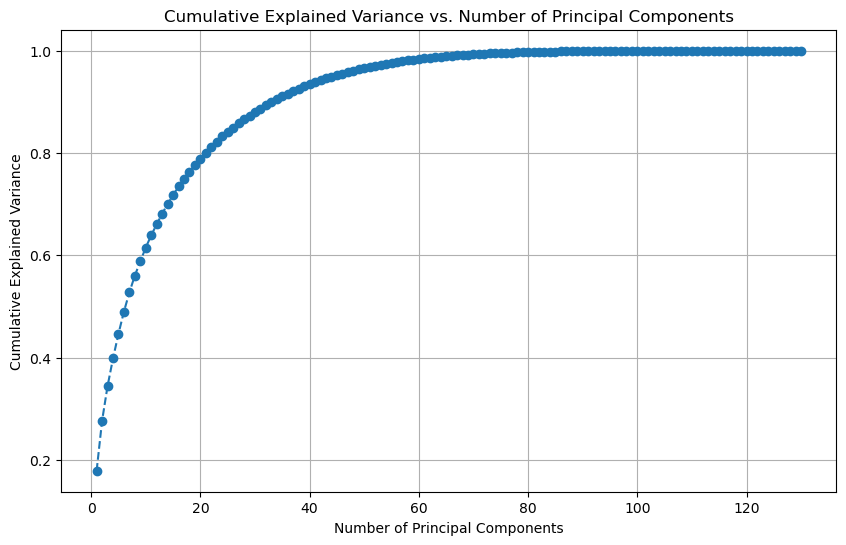

最优维度: 34


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,y
0,5.131936,3.769983,-6.154328,0.547307,-3.210922,1.760692,-0.678131,-0.676654,-0.526823,-0.842350,...,-0.211716,-1.858667,1.165487,0.718409,0.785271,-1.775999,1.220605,-0.854087,1.351284,4.0
1,0.474598,-1.728035,-2.816260,-0.018593,-0.903522,1.138728,2.547025,-0.077557,0.136633,-0.233948,...,1.243192,-0.216683,-1.841741,0.174806,0.107572,-0.412993,-0.561401,-0.426906,0.434536,0.0
2,6.411658,-3.646761,-4.157505,-0.740157,0.418454,1.010938,-0.037736,-2.047478,-0.845828,1.090684,...,0.013179,0.647058,0.182888,0.827868,1.392221,0.226719,-0.618003,-0.114827,-0.433821,5.0
3,2.515014,-4.228712,3.254390,-4.832276,2.086630,0.338946,-1.291389,0.739262,0.619828,-1.408660,...,1.702947,-1.491896,0.583643,0.021512,0.564044,0.184927,-0.879582,-1.168728,-0.613719,4.0
4,2.548699,-0.038155,0.052354,-1.421760,-3.701031,2.174421,-1.324157,-0.327897,1.162688,-0.632715,...,-0.784370,0.650695,-0.141000,-1.568023,-0.469145,-1.345744,-0.872802,-0.074427,1.099728,3.0


In [68]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json

# 假设data2_need_pca是你的DataFrame，其中第一列是y，其他列是x，包括缺失值
y = data2_need_pca.iloc[:, 0]
X = data2_need_pca.iloc[:, 1:]

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用迭代PCA的方式处理缺失值
imputer = IterativeImputer(max_iter=10, random_state=0)  # 可以根据需要调整max_iter参数
X_imputed = imputer.fit_transform(X_scaled)

# 初始化PCA模型
pca = PCA()

# 拟合PCA模型
pca.fit(X_imputed)

# 累积解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# 绘制累积解释方差比例的图形
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()

# 将x轴和y轴对应的值保存到JSON文件
json_data = {
    "x_axis": list(range(1, len(cumulative_explained_variance) + 1)),
    "y_axis": list(cumulative_explained_variance)
}

with open('explained_variance.json', 'w') as json_file:
    json.dump(json_data, json_file)

plt.show()

# 寻找最接近0.9的累积解释方差的维度
target_variance = 0.9
optimal_dimension = next(i for i, var in enumerate(cumulative_explained_variance) if var >= target_variance) + 1  # 加1是因为索引从0开始

# 根据最优维度重新进行PCA
pca = PCA(n_components=optimal_dimension)
X_pca = pca.fit_transform(X_imputed)

# 创建一个新的DataFrame包含最优维度的主成分
column_names = [f"PC{i+1}" for i in range(optimal_dimension)]
df_pca = pd.DataFrame(data=X_pca, columns=column_names)

# 将y列添加回DataFrame
df_pca['y'] = y

# 打印最优维度
print(f"最优维度: {optimal_dimension}")

# 保存新的DataFrame到文件
df_pca.to_csv('pca_result.csv', index=False)  # 保存到csv文件中，你可以修改文件名和路径

# 打印新的DataFrame的前几行
df_pca.head()


In [69]:
df_pca.to_csv('q32_df_pca.csv', index=False)